<a href="https://colab.research.google.com/github/imaizumi0302/store_sales_prediction/blob/main/store_sales%E3%83%87%E3%83%BC%E3%82%BF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ライブラリ読み込み

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gc
import os
import datetime as dt

import warnings
warnings.filterwarnings('ignore')



from sklearn.metrics import mean_squared_log_error

import xgboost as xgb
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler,OneHotEncoder
import shap



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
#trainデータ読み込み
train = pd.read_csv("/content/drive/MyDrive/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/train.csv")
print(train.shape)
train.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
#storeデータ読み込み
store = pd.read_csv("/content/drive/MyDrive/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/stores.csv")
print(store.shape)
store.head()

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
oil = pd.read_csv("/content/drive/MyDrive/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/oil.csv")
print(oil.shape)
oil.head()

(1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [ ]:
# データのそもそもない土日祝日などを補間
oil["date"] = pd.to_datetime(oil["date"])
oil = (
    oil.set_index("date")
    .resample("D")
    .ffill()
)

In [ ]:
oil["dcoilwtico"] = oil['dcoilwtico'].ffill()

In [ ]:
oil['dcoilwtico'].bfill(inplace = True)

In [ ]:
holidays = pd.read_csv("/content/drive/MyDrive/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/holidays_events.csv")
print(holidays.shape)
holidays.tail()

(350, 6)


,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [ ]:
print(store["city"].unique())
print(store["state"].unique())
print(holidays["locale"].unique())
print(holidays["locale_name"].unique())


['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']
['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']
['Local' 'Regional' 'National']
['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']


#学習データ

#データフレーム結合

In [ ]:
train = pd.merge(train,store,on="store_nbr",how="left")
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [ ]:
#データタイプをdatetimeに変換
train["date"] = pd.to_datetime(train["date"])

In [ ]:
train = pd.merge(train,oil,on="date",how="left")
print(train.shape)
train.head()

(3000888, 11)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14


#データ探索

In [ ]:
train.dtypes

,0
id,int64
date,datetime64[ns]
store_nbr,int64
family,object
sales,float64
onpromotion,int64
city,object
state,object
type,object
cluster,int64


In [ ]:
train.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
city,0
state,0
type,0
cluster,0


In [ ]:
#各変数のユニークな値の数を確認

family_nunique = train["family"].nunique()
store_nbr_nunique = train["store_nbr"].nunique()
date_nunique = train["date"].nunique()
onpromotion_nunique = train["onpromotion"].nunique()
type_nunique = train["type"].nunique()
cluster_nunique = train["cluster"].nunique()

print("familyのユニーク数:", family_nunique)
print("store_nbrのユニーク数:", store_nbr_nunique)
print("dateのユニーク数:", date_nunique)
print("onpromotionのユニーク数:", onpromotion_nunique)
print("typeのユニーク数:", type_nunique)
print("clusterのユニーク数:", cluster_nunique)

familyのユニーク数: 33
store_nbrのユニーク数: 54
dateのユニーク数: 1684
onpromotionのユニーク数: 362
typeのユニーク数: 5
clusterのユニーク数: 17


In [ ]:
#各変数のユニークな値の種類を確認

family_unique = train["family"].unique()
store_nbr_unique = train["store_nbr"].unique()
date_unique = train["date"].unique()
onpromotion_unique = train["onpromotion"].unique()

print("familyのユニークの種類:", family_unique)
print("store_nbrのユニークの種類:", store_nbr_unique)
print("dateのユニークの種類:", date_unique)
print("onpromotionのユニークの種類:", onpromotion_unique)

familyのユニークの種類: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
store_nbrのユニークの種類: [ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]
dateのユニークの種類: <DatetimeArray>
['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
 '2013-01-04 00:00:00', '2013-01-05 00:00:00', '2013-01-06 00:00:00',
 '2013-01-07 00:00:00', '2013-01-08 00:00:00', '2013-01-09 00:00:00',
 '2013-01-10 00:00:00',
 ...
 '2017-08-06 00:00:00', '2017-08-07 00:00:00', '2017-08-08 00:00:00'

In [ ]:
# 最初の日と最後の日を取得
start_date = train["date"].min()
end_date = train["date"].max()

print("最初の日:", start_date)
print("最後の日:", end_date)

最初の日: 2013-01-01 00:00:00
最後の日: 2017-08-15 00:00:00


In [ ]:
train.groupby("family")["date"].count()

,date
family,
AUTOMOTIVE,90936
BABY CARE,90936
BEAUTY,90936
BEVERAGES,90936
BOOKS,90936
BREAD/BAKERY,90936
CELEBRATION,90936
CLEANING,90936
DAIRY,90936


In [ ]:
train.describe()

,id,date,store_nbr,sales,onpromotion,cluster,dcoilwtico
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00,8.481481e+00,6.792490e+01
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.637750e+01
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,5.341000e+01
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00,1.300000e+01,9.572000e+01
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01,4.649735e+00,2.566913e+01


In [ ]:
train["onpromotion"].unique()

array([  0,   3,   5,   1,  56,  20,  19,   2,   4,  18,  17,  12,   6,
         7,  10,   9,  50,   8,  16,  42,  51,  13,  15,  47,  21,  40,
        37,  54,  24,  58,  22,  59,  11,  45,  25,  55,  26,  43,  35,
        14,  28,  46,  36,  32,  53,  57,  27,  39,  41,  30,  29,  49,
        23,  48,  44,  38,  31,  52,  33,  34,  61,  60, 116,  86,  73,
       113, 102,  68, 104,  93,  70,  92, 121,  72, 178, 174, 161, 118,
       105, 172, 163, 167, 142, 154, 133, 180, 181, 173, 165, 168, 186,
       140, 149, 145, 169, 188,  62,  84, 111,  65, 107,  63, 101,  87,
       125,  94, 114, 171, 153, 170, 166, 141, 155, 179, 192, 131, 147,
       151, 189,  79,  74, 110,  64,  67,  99, 123, 157, 117, 150, 182,
       162, 160, 194, 135, 190,  69, 108,  89, 126, 156, 103, 146, 132,
       177, 164, 176, 112,  75, 109,  91, 128, 175, 187, 148, 137, 184,
       196, 144, 158, 119, 106,  66, 100,  90, 120, 115,  98, 159, 152,
       185, 139, 143,  80, 124,  71, 134, 193,  78,  88, 122, 13

In [ ]:
#onpromotionの数ごとの売り上げ確認
train.groupby("onpromotion")["sales"].mean()

,sales
onpromotion,
0,158.246681
1,467.556532
2,662.925632
3,871.408092
4,969.916135
...,...
719,6681.000000
720,6154.000000
722,5846.000000


In [ ]:
#stateとcityごとにカウント
train.groupby(["state","city"])["store_nbr"].count()

state                           city         
Azuay                           Cuenca            166716
Bolivar                         Guaranda           55572
Chimborazo                      Riobamba           55572
Cotopaxi                        Latacunga         111144
El Oro                          Machala           111144
Esmeraldas                      Esmeraldas         55572
Guayas                          Daule              55572
                                Guayaquil         444576
                                Libertad           55572
                                Playas             55572
Imbabura                        Ibarra             55572
Loja                            Loja               55572
Los Rios                        Babahoyo           55572
                                Quevedo            55572
Manabi                          El Carmen          55572
                                Manta             111144
Pastaza                         Puyo               55572
Pichincha                       Cayambe            55572
                                Quito            1000296
Santa Elena                     Salinas            55572
Santo Domingo de los Tsachilas  Santo Domingo     166716
Tungurahua                      Ambato            111144
Name: store_nbr, dtype: int64

In [ ]:
#typeごとの売り上げ確認
train.groupby("type")["sales"].mean()

,sales
type,
A,705.878743
B,326.739714
C,197.263301
D,350.979407
E,269.121301


In [ ]:
#clusterごとの売り上げ確認
train.groupby("cluster")["sales"].mean()

,sales
cluster,
1,326.163967
2,260.170621
3,194.416262
4,296.572872
5,1117.245254
6,342.661732
7,139.261863
8,647.377856
9,274.968339


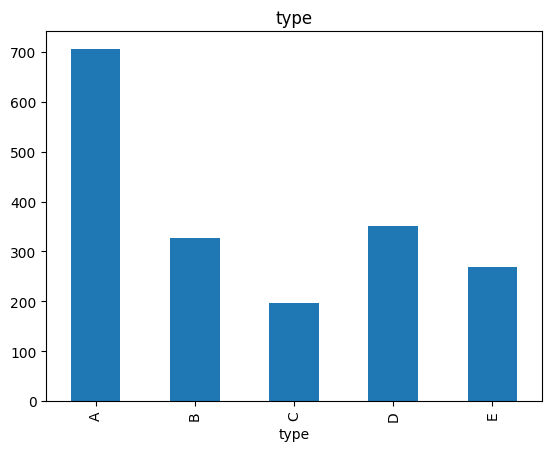

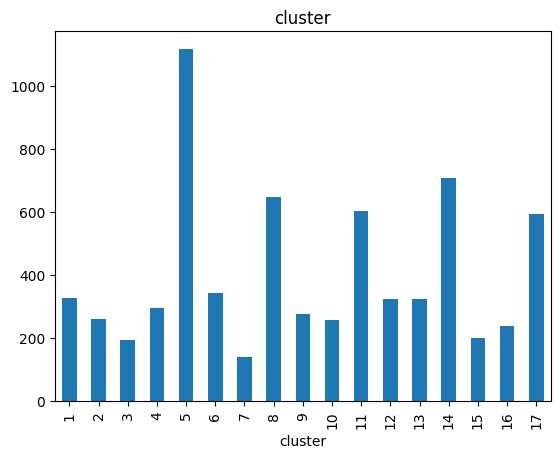

In [ ]:
#typeごとの売り上げとclusterごとの売り上げをバーチャートで描画
for col in ["type","cluster"]:
  train.groupby(col)["sales"].mean().plot(kind="bar")
  plt.title(col)
  plt.show()


#特徴量エンジニアリング

##日付データを分解

In [ ]:
# store_nbrとfamilyごとに日付順にソート
train = train.sort_values(["store_nbr", "family", "date"])

# 日付を分解して特徴量に
train["year"] = train["date"].dt.year
train["month"] = train["date"].dt.month
train["day"] = train["date"].dt.day

#曜日を分解して特徴量に(0が月曜日)
train["weekday"] = train["date"].dt.weekday

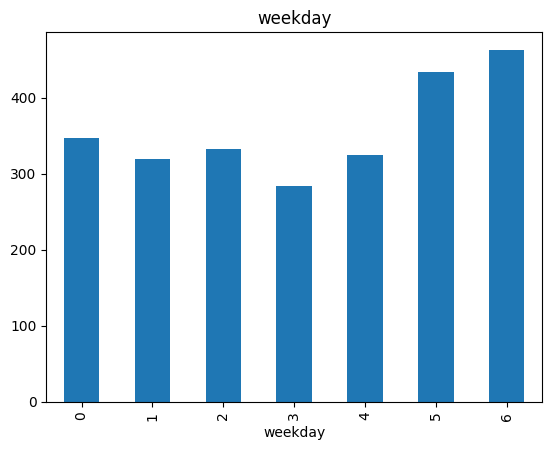

In [ ]:
#曜日ごとの売り上げ平均を確認
train.groupby("weekday")["sales"].mean().plot(kind="bar")
plt.title("weekday")
plt.show()

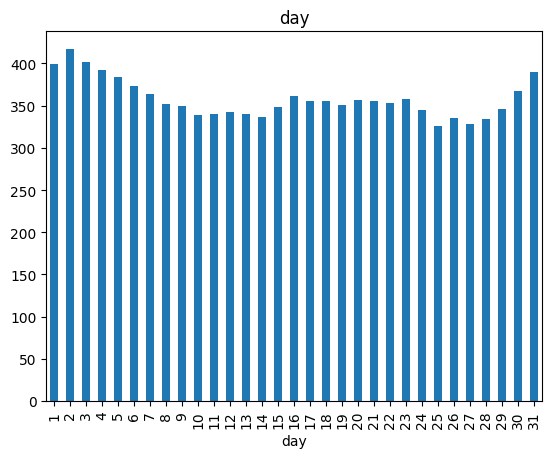

In [ ]:
#日付ごとの売り上げ平均を確認
train.groupby("day")["sales"].mean().plot(kind="bar")
plt.title("day")
plt.show()

##土日フラグ作成

In [ ]:
# 土日フラグを作成
train["is_weekend"] = train["weekday"].isin([5, 6]).astype(int)

##カラムごとの平均売り上げを作成する関数を作成


In [ ]:
def sales_by_column(df,col):
  #データ流出を防ぐため、訓練データに使われる2017-6-30以前のデータに制限
  train_past_sales = df[df["date"] <= "2017-06-30"]
  #指定のカラムごとに売り上げの平均を作成
  sales_by_col = train_past_sales.groupby(col)["sales"].mean().reset_index()
  #trainデータと売り上げ平均をしてにカラムをキーにして結合
  df = pd.merge(df,sales_by_col,on=col,how="left")
  #カラム目の変更処理
  df = df.rename(columns={"sales_x":"sales","sales_y":f"sales_by_{col}"})

  return df

In [ ]:
#カラムごとの平均売り上げを作成
train = sales_by_column(train,"store_nbr")
train = sales_by_column(train,"family")
train = sales_by_column(train,"type")
train = sales_by_column(train,"cluster")

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,year,month,day,weekday,is_weekend,sales_by_store_nbr,sales_by_family,sales_by_type,sales_by_cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,2013,1,1,1,0,253.035259,6.066624,348.454778,321.979068
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,93.14,2013,1,2,2,0,253.035259,6.066624,348.454778,321.979068
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,92.97,2013,1,3,3,0,253.035259,6.066624,348.454778,321.979068
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,93.12,2013,1,4,4,0,253.035259,6.066624,348.454778,321.979068
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,93.12,2013,1,5,5,1,253.035259,6.066624,348.454778,321.979068


##2つのカラムでグループ化して、平均を算出する関数を作成

In [ ]:
def sales_by_columns(df,col1,col2):
  #データ流出を防ぐため、訓練データに使われる2017-6-30以前のデータに制限
  train_past_sales = df[df["date"] <= "2017-06-30"]

  #過去のデータをcol1とcol2ごとにグループ化して平均を算出
  past_sale_mean = train_past_sales.groupby([col1,col2])["sales"].mean().reset_index()

  #求めたcol1とcol2ごとの平均をもとのデータフレームと結合
  df = pd.merge(df,past_sale_mean,on=[col1,col2],how="left")
  df = df.rename(columns={"sales_x":"sales","sales_y":f"sales_by_{col1}_{col2}"})

  return df

In [ ]:
#2つのカラムでグループ化したときの平均売り上げカラムを作成
train = sales_by_columns(train,"store_nbr","family")

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,year,month,day,weekday,is_weekend,sales_by_store_nbr,sales_by_family,sales_by_type,sales_by_cluster,sales_by_store_nbr_family
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,2013,1,1,1,0,253.035259,6.066624,348.454778,321.979068,3.209402
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,...,2013,1,2,2,0,253.035259,6.066624,348.454778,321.979068,3.209402
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,2013,1,3,3,0,253.035259,6.066624,348.454778,321.979068,3.209402
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,2013,1,4,4,0,253.035259,6.066624,348.454778,321.979068,3.209402
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,...,2013,1,5,5,1,253.035259,6.066624,348.454778,321.979068,3.209402


##移動平均を作成



In [ ]:
# 移動平均特徴量の作成
for window in [3, 7, 30]:
    train[f"rolling_mean_{window}"] = (
        train.groupby(["store_nbr", "family"])["sales"]
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())
    )

# 各店舗×商品ごとの最終日（8/15）時点の値を抽出
rolling_features = (
    train.groupby(["store_nbr", "family"])[["rolling_mean_3", "rolling_mean_7", "rolling_mean_30"]]
    .last()
    .reset_index()
)

# テストデータにマージ
# test = test.merge(rolling_features, on=["store_nbr", "family"], how="left")


In [ ]:
for col in ["rolling_mean_3", "rolling_mean_7", "rolling_mean_30"]:
    train[col].bfill(inplace=True)

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,weekday,is_weekend,sales_by_store_nbr,sales_by_family,sales_by_type,sales_by_cluster,sales_by_store_nbr_family,rolling_mean_3,rolling_mean_7,rolling_mean_30
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,1,0,253.035259,6.066624,348.454778,321.979068,3.209402,0.000000,0.000000,0.000000
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,...,2,0,253.035259,6.066624,348.454778,321.979068,3.209402,0.000000,0.000000,0.000000
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,3,0,253.035259,6.066624,348.454778,321.979068,3.209402,1.000000,1.000000,1.000000
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,4,0,253.035259,6.066624,348.454778,321.979068,3.209402,1.666667,1.666667,1.666667
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,...,5,1,253.035259,6.066624,348.454778,321.979068,3.209402,2.666667,2.000000,2.000000


##oilの移動平均を作成

In [ ]:
# oilの移動平均特徴量の作成
# 日付順に並べる
oil = oil.sort_values("date")

# 15日・30日・90日の移動平均を作成
oil["oil_mean_180"] = oil["dcoilwtico"].rolling(window=180, min_periods=1).mean()
oil["oil_mean_30"] = oil["dcoilwtico"].rolling(window=30, min_periods=1).mean()
oil["oil_mean_90"] = oil["dcoilwtico"].rolling(window=90, min_periods=1).mean()


In [ ]:
oil[["oil_mean_180", "oil_mean_30", "oil_mean_90"]].corr()


,oil_mean_180,oil_mean_30,oil_mean_90
oil_mean_180,1.000000,0.953027,0.982388
oil_mean_30,0.953027,1.000000,0.987055
oil_mean_90,0.982388,0.987055,1.000000


In [ ]:
train = pd.merge(train, oil, on="date", how="left")
train = train.drop(columns = "dcoilwtico_y",axis = 1)
train = train.rename(columns={"dcoilwtico_x":"dcoilwtico"})

##祝日フラグ付け

In [ ]:
holidays['date'] = pd.to_datetime(holidays['date'])

In [ ]:
# 祝日フラグを作成（Transfer, Bridge, Additional も含める）
holidays['is_holiday'] = holidays['type'].isin(['Holiday', 'Transfer', 'Bridge', 'Additional']).astype(int)

regional = holidays[
    (holidays['locale'] == 'Regional') & (holidays['is_holiday'] == 1)
][['date', 'locale_name']].drop_duplicates()

regional.head()


,date,locale_name
1,2012-04-01,Cotopaxi
7,2012-06-25,Imbabura
23,2012-11-06,Santo Domingo de los Tsachilas
24,2012-11-07,Santa Elena
47,2013-04-01,Cotopaxi


In [ ]:
# 2) 列名を一致させる（locale_name を state としてマージできるようにする）
regional = regional.rename(columns={'locale_name': 'state'})

In [ ]:
# 3) 日付型を揃える（重要）
train['date'] = pd.to_datetime(train['date'])


In [ ]:
# 4) merge（left join で train の行数はそのまま、該当があれば情報が付く）
train = train.merge(regional.assign(is_regional_holiday=1), on=['date', 'state'], how='left')
train

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,sales_by_type,sales_by_cluster,sales_by_store_nbr_family,rolling_mean_3,rolling_mean_7,rolling_mean_30,oil_mean_180,oil_mean_30,oil_mean_90,is_regional_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,348.454778,321.979068,3.209402,0.000000,0.000000,0.000000,93.140000,93.140000,93.140000,NaN
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,...,348.454778,321.979068,3.209402,0.000000,0.000000,0.000000,93.140000,93.140000,93.140000,NaN
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,348.454778,321.979068,3.209402,1.000000,1.000000,1.000000,93.083333,93.083333,93.083333,NaN
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,348.454778,321.979068,3.209402,1.666667,1.666667,1.666667,93.092500,93.092500,93.092500,NaN
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,...,348.454778,321.979068,3.209402,2.666667,2.000000,2.000000,93.098000,93.098000,93.098000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2993627,2017-08-11,54,SEAFOOD,0.0,0,El Carmen,Manabi,C,3,...,195.438018,192.396556,1.711233,6.000000,3.000000,2.966667,48.693500,48.071000,47.033778,NaN
3000884,2995409,2017-08-12,54,SEAFOOD,1.0,1,El Carmen,Manabi,C,3,...,195.438018,192.396556,1.711233,2.000000,3.000000,2.933333,48.670444,48.162667,47.044667,NaN
3000885,2997191,2017-08-13,54,SEAFOOD,2.0,0,El Carmen,Manabi,C,3,...,195.438018,192.396556,1.711233,1.000000,2.714286,2.966667,48.646000,48.238667,47.044111,NaN
3000886,2998973,2017-08-14,54,SEAFOOD,0.0,0,El Carmen,Manabi,C,3,...,195.438018,192.396556,1.711233,1.000000,3.000000,3.033333,48.615333,48.274000,47.032444,NaN


In [ ]:
# 5) フラグ化（NaN -> 0）
train['is_regional_holiday'] = train['is_regional_holiday'].fillna(0).astype(int)

In [ ]:
train["is_holiday_flag"] = 0

In [ ]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'dcoilwtico', 'year', 'month', 'day',
       'weekday', 'is_weekend', 'sales_by_store_nbr', 'sales_by_family',
       'sales_by_type', 'sales_by_cluster', 'sales_by_store_nbr_family',
       'rolling_mean_3', 'rolling_mean_7', 'rolling_mean_30', 'oil_mean_180',
       'oil_mean_30', 'oil_mean_90', 'is_regional_holiday', 'is_holiday_flag'],
      dtype='object')

In [ ]:
# 6) 統合フラグに反映（既に is_holiday_flag があるなら OR）
train['is_holiday_flag'] = ((train['is_holiday_flag'] == 1) | (train['is_regional_holiday'] == 1))


In [ ]:
train["is_holiday_flag"].astype(int)

,is_holiday_flag
0,0
1,0
2,0
3,0
4,0
...,...
3000883,0
3000884,0
3000885,0
3000886,0


In [ ]:
# national
national = holidays[(holidays['locale']=='National') & (holidays['is_holiday']==1)][['date']].drop_duplicates()
train = train.merge(national.assign(is_national_holiday=1), on='date', how='left')
train['is_national_holiday'] = train['is_national_holiday'].fillna(0).astype(int)

# local (city)
local = holidays[(holidays['locale']=='Local') & (holidays['is_holiday']==1)][['date','locale_name']].drop_duplicates()
local = local.rename(columns={'locale_name':'city'})
train = train.merge(local.assign(is_local_holiday=1), on=['date','city'], how='left')
train['is_local_holiday'] = train['is_local_holiday'].fillna(0).astype(int)

# 最終的な休みフラグ（必要に応じて OR）
train['is_holiday_flag'] = ((train['is_national_holiday']==1) |
                            (train['is_regional_holiday']==1) |
                            (train['is_local_holiday']==1)).astype(int)

In [ ]:
# 最終的な休みフラグ（必要に応じて OR）
train['is_holiday_flag'] = ((train['is_national_holiday']==1) |
                            (train['is_regional_holiday']==1) |
                            (train['is_local_holiday']==1)).astype(int)


In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,rolling_mean_3,rolling_mean_7,rolling_mean_30,oil_mean_180,oil_mean_30,oil_mean_90,is_regional_holiday,is_holiday_flag,is_national_holiday,is_local_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,0.000000,0.000000,0.000000,93.140000,93.140000,93.140000,0,1,1,0
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,...,0.000000,0.000000,0.000000,93.140000,93.140000,93.140000,0,0,0,0
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,1.000000,1.000000,1.000000,93.083333,93.083333,93.083333,0,0,0,0
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,1.666667,1.666667,1.666667,93.092500,93.092500,93.092500,0,0,0,0
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,...,2.666667,2.000000,2.000000,93.098000,93.098000,93.098000,0,0,0,0


##データタイプ変換

In [ ]:
train.dtypes

,0
id,int64
date,datetime64[ns]
store_nbr,int64
family,object
sales,float64
onpromotion,int64
city,object
state,object
type,object
cluster,int64


In [ ]:
features_type_changed = ["family","type"]
for col in features_type_changed:
  train[col] = train[col].astype("category")


#データセット作成

In [ ]:
# 説明変数と目的変数のリスト作成
#dateカラムそのものは、datetimeになっているため、説明変数には含めない
tr_features = ["store_nbr","family","sales_by_store_nbr", "sales_by_family", "onpromotion", "year", "month", "day","weekday",
               "sales_by_store_nbr_family","rolling_mean_3","rolling_mean_7",
               "rolling_mean_30","sales_by_type","sales_by_cluster","dcoilwtico","oil_mean_30", "oil_mean_90"]

target = "sales"

In [ ]:
x_all = train[tr_features]
y_all = train[target]
print(x_all.shape)
print(y_all.shape)

#このあとにsortなどをすると、順番が崩れるので、それは行わない。

(3000888, 18)
(3000888,)


#学習データと検証データの期間設定

・今回のコンペでは、テストデータが2017/8/16-2017/8/31までの16日間  
→検証データも16日間分に設定して、期間は7/31~8/15までの16日間

〇学習データは3つの期間に設定  
期間1:2013/1/1 ~ 2017/6/30  
期間2:2013/1/1 ~ 2017/7/15  
期間3:2013/1/1 ~ 2017/7/31  

In [ ]:
#学習データと検証データの期間設定
# 検証期間を16日間ずつ設定
folds = [
    {"train_end": "2017-06-30", "val_start": "2017-07-01", "val_end": "2017-07-16"},
    {"train_end": "2017-07-15", "val_start": "2017-07-17", "val_end": "2017-08-01"},
    {"train_end": "2017-07-30", "val_start": "2017-07-31", "val_end": "2017-08-15"},
]

#LightGBM交差検証学習用モデル作成


# ------------------------------
# 3-fold 日付単位時系列交差検証
# ------------------------------

In [ ]:
import optuna

In [ ]:
#ハイパーパラメータの設定
# params = {
#     "n_estimators":1000,
#     "learning_rate":0.05,
#     "num_leaves":32
# }

In [ ]:
def objective(trial):
    # チューニングしたいハイパーパラメータを定義
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "n_estimators": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 1.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 1.0),
        "verbose": -1
    }

    # train_lgb関数を呼び出して平均RMSLEを返す
    df_valid_pred,df_imp,df_metrics = train_lgb(
        original_df=train,
        input_x=x_all,
        input_y=y_all,
        list_nfold=[0,1,2],
        params=params,
        folds=folds
    )

    mean_rmsle = df_metrics["rmsle"].mean()

    return mean_rmsle  # Optunaはこれを最小化


#モデル学習用関数作成

In [ ]:
#訓練データと検証データのindex作成
# foldsの中から、今回設定した範囲を取り出し、その範囲に入っているかどうかを判断し、その範囲内のデータのみを訓練データと検証データとしていく。
#これを3周する


def train_lgb(original_df,
              input_x,
              input_y,
              list_nfold=[0,1,2],
              params=None,#params,
              folds=folds
              ):

  #推論値を格納する変数の作成
  df_valid_pred = pd.DataFrame()
  #評価値を入れる変数の作成
  metrics = []
  #重要度を格納するデータフレームの作成
  df_imp = pd.DataFrame()
  #モデルを格納するリストの作成
  models = []

  for i,nfold in enumerate(list_nfold):
      # 学習用
      train_idx = original_df["date"] <= folds[nfold]["train_end"]
      x_tr = input_x[train_idx]
      y_tr = input_y[train_idx]

      # 検証用
      val_idx = (original_df["date"] >= folds[nfold]["val_start"]) & (original_df["date"] <= folds[nfold]["val_end"])
      x_val = input_x[val_idx]
      y_val = input_y[val_idx]

      # LightGBM モデル
      model = lgb.LGBMRegressor(**params)


      # モデルの訓練
      model.fit(
          x_tr, y_tr,
          eval_set=[(x_val, y_val)],
          eval_metric="rmse",
          callbacks=[
          early_stopping(stopping_rounds=50),  # 早期停止
          log_evaluation(50)                   # 50回ごとにログ表示
      ]
      )
      #保存するモデルのファイル名
      filename = "model_lgb_fold{}.pickle".format(nfold)

      #モデルを保存
      with open(filename, 'wb') as f:
        pickle.dump(model, f, protocol=4)

      # 検証スコア（RMSLE）
      y_pred = model.predict(x_val)
      rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(0, y_pred)))
      print(f"Fold {i+1} RMSLE: {rmsle:.4f}")

      #検証スコアを各foldごとに格納 #あとでデータフレーム型に変更
      metrics.append([nfold,rmsle])


      #各foldごとに実際の値と予測値を格納したDataFrameを作成
      df_pred = pd.DataFrame({"nfold":nfold,"true":y_val,"pred":y_pred})
      df_valid_pred = pd.concat([df_valid_pred,df_pred],axis = 0,ignore_index=True)

      #各foldごとに各変数の重要度を格納したデータフレームを作成
      tmp_imp = pd.DataFrame({"nfold":nfold,"col":x_tr.columns,"imp":model.feature_importances_})
      df_imp = pd.concat([df_imp,tmp_imp])

  print("-"*10,"result","-"*10)

  #各foldごとの評価値をデータフレームに格納
  df_metrics = pd.DataFrame(metrics,columns = ["nfold","rmsle"])
  print("各foldの評価値の平均:{:.2f}".format(df_metrics['rmsle'].mean()))

  return df_valid_pred,df_imp,df_metrics

In [ ]:
# Studyの作成（最小化）
study = optuna.create_study(direction="minimize")

# 最適化を実行
study.optimize(objective, n_trials=30)

# 結果の表示
print("================================")
print("✅ 最良スコア:", study.best_value)
print("✅ 最良パラメータ:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


In [ ]:
# 探索しないハイパーパラメータ
# params_base = {
#     "boosting_type": "gbdt",
#     "objective": "binary",
#     "metric": "rmse",
#     "verbosity": -1,
#     "learning_rate": 0.05,
#     "n_estimators": 10000,
#     "bagging_freq": 1
#}

#モデル学習

In [ ]:
# Optunaで得られた最良パラメータ
best_params = study.best_params

df_valid_pred,df_imp,df_metrics = train_lgb(train,
                                            x_all,
                                            y_all,
                                            list_nfold=[0,1,2],
                                            params=best_params,
                                            folds=folds
                                            )

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.215030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2248
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 18
[LightGBM] [Info] Start training from score 354.309666
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 301.481	valid_0's l2: 90890.5
[100]	valid_0's rmse: 238.774	valid_0's l2: 57013.1
[150]	valid_0's rmse: 229.464	valid_0's l2: 52653.6
[200]	valid_0's rmse: 225.753	valid_0's l2: 50964.4
[250]	valid_0's rmse: 223.93	valid_0's l2: 50144.5
[300]	valid_0's rmse: 221.391	valid_0's l2: 49014
[350]	valid_0's rmse: 219.745	valid_0's l2: 48288
[400]	valid_0's rmse: 219.003	valid_0's l2: 47962.2
[450]	valid_0's rmse: 217.451	valid_0's l2: 47284.9
[500]	valid_0's rmse: 216.604	valid_0's l2: 46917.4
[550]	valid_0's

In [ ]:
#各foldの評価値の平均
print("各foldの評価値の平均:{:.2f}".format(df_metrics['rmsle'].mean()))

各foldの評価値の平均:0.57


In [ ]:
#各変数ごとに3回のfoldでの重要度の平均を算出
#今回のモデルでどの変数が予測値を出すうえで、より大きな影響を与えているかがわかる
df_imp_mean = df_imp.groupby("col")["imp"].agg(["mean","std"]).sort_values("mean",ascending=False)
df_imp_mean

,mean,std
col,,
day,3404.666667,84.387993
weekday,2961.333333,36.295087
rolling_mean_7,2146.000000,54.561891
oil_mean_90,2124.333333,116.629042
sales_by_store_nbr,2077.000000,13.000000
onpromotion,2056.666667,27.574142
rolling_mean_3,2032.000000,61.392182
store_nbr,2005.000000,86.556340
dcoilwtico,1976.000000,75.319320


In [ ]:
#各foldの予測値を格納したデータフレーム表示
df_valid_pred

,nfold,true,pred
0,0,7.0,8.473023
1,0,4.0,7.735408
2,0,0.0,11.225218
3,0,5.0,8.235598
4,0,1.0,6.003962
...,...,...,...
85531,2,0.0,3.550863
85532,2,1.0,-0.440987
85533,2,2.0,0.199525
85534,2,0.0,0.116710


#SHAP値

==== Fold 0 Summary SHAP ====


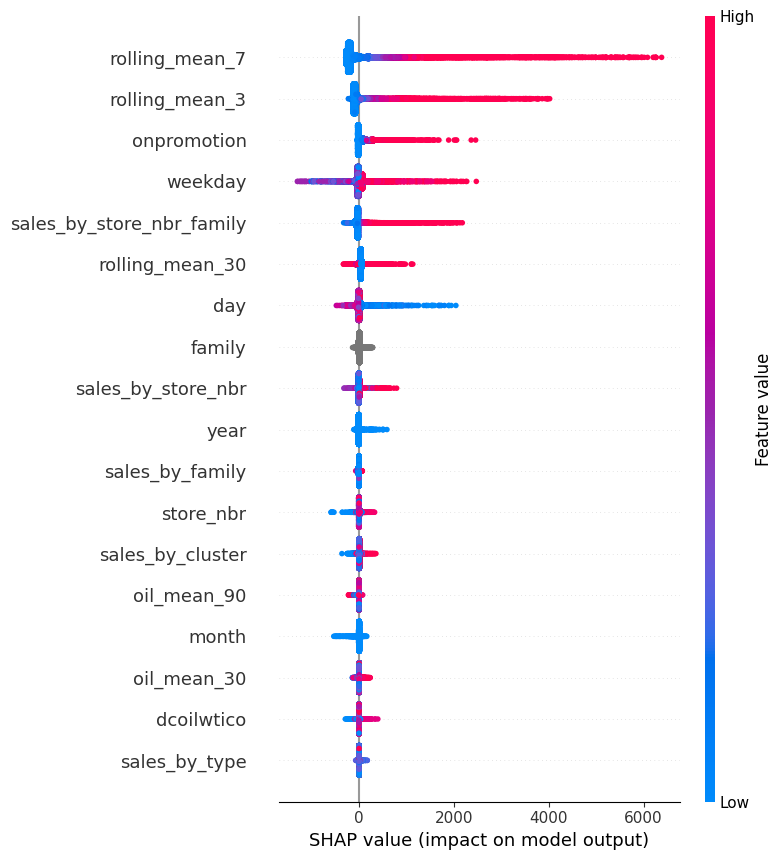

==== Fold 0 Individual Prediction SHAP ====


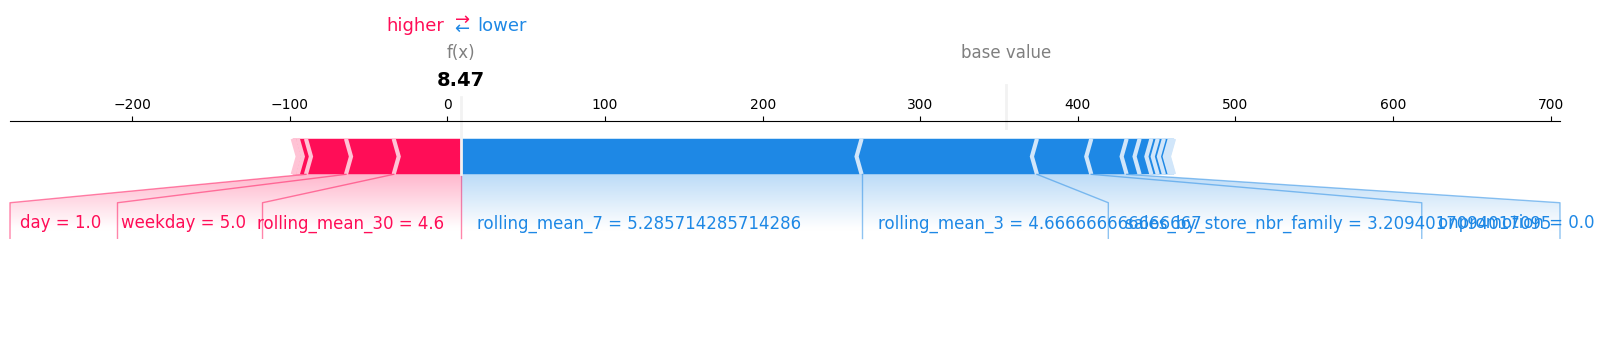

==== Fold 1 Summary SHAP ====


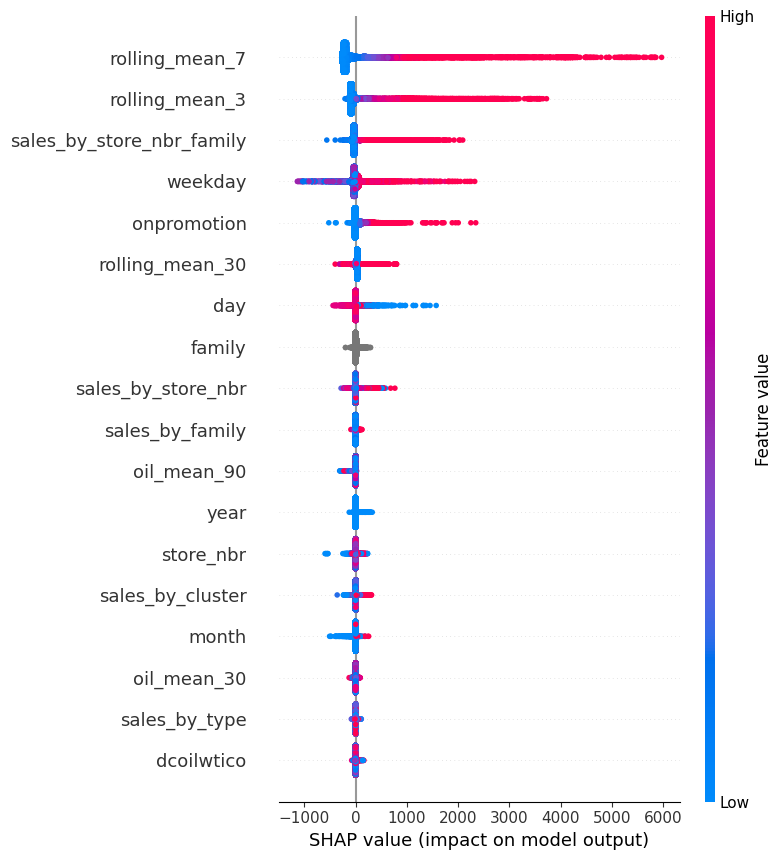

==== Fold 1 Individual Prediction SHAP ====


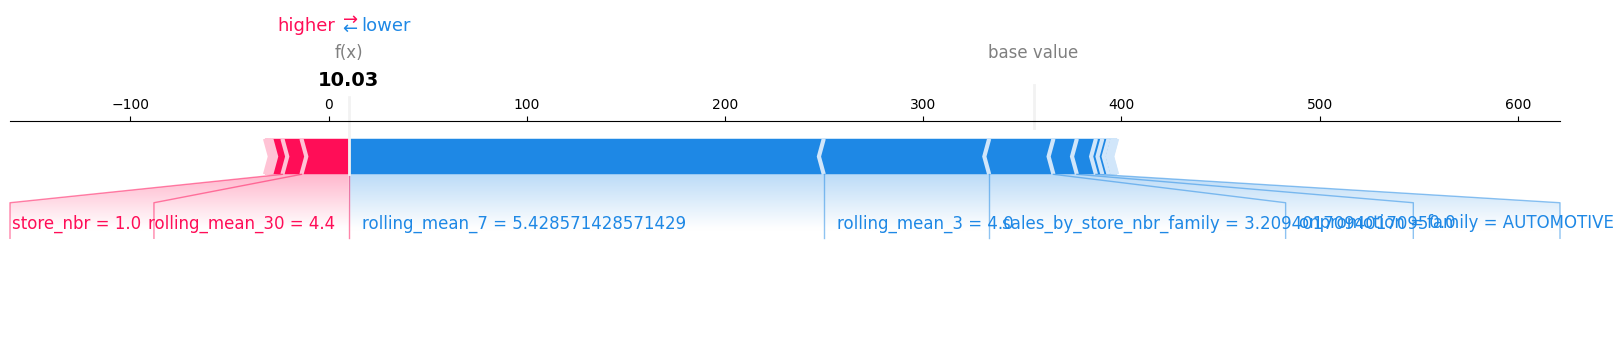

==== Fold 2 Summary SHAP ====


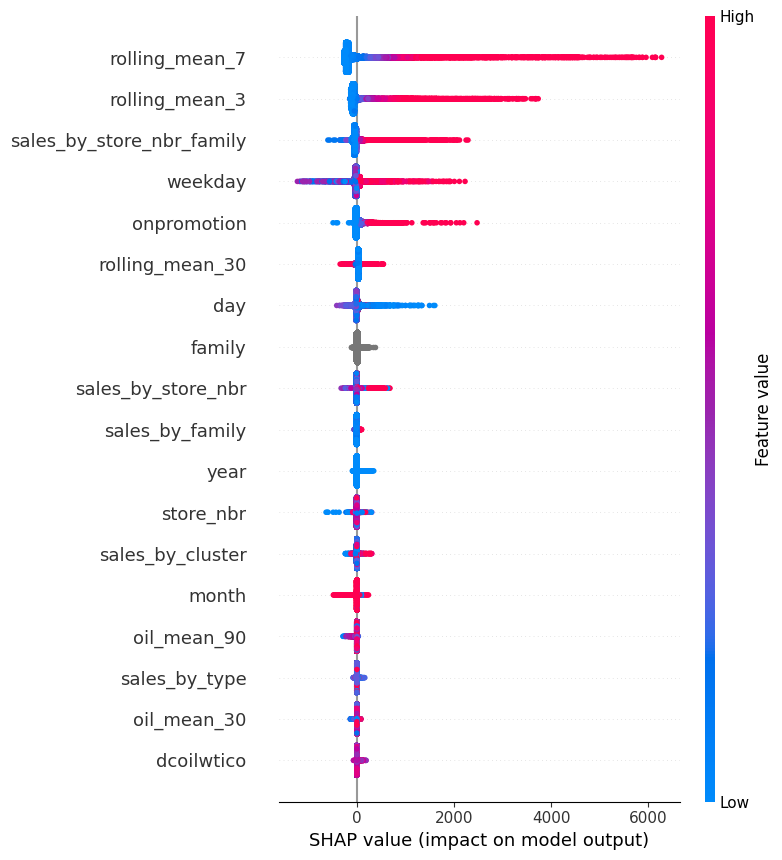

==== Fold 2 Individual Prediction SHAP ====


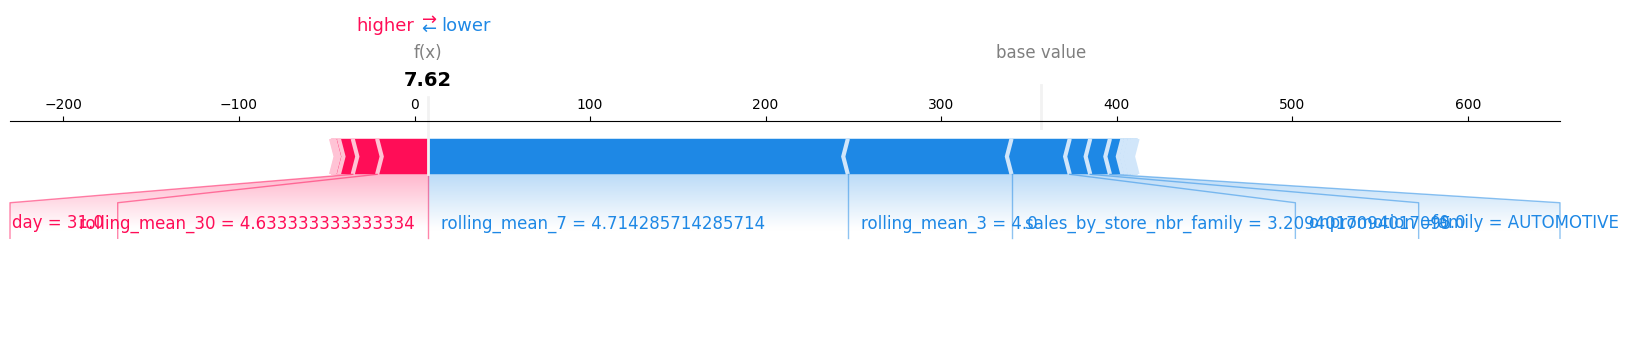

==== Approximate Average SHAP ====


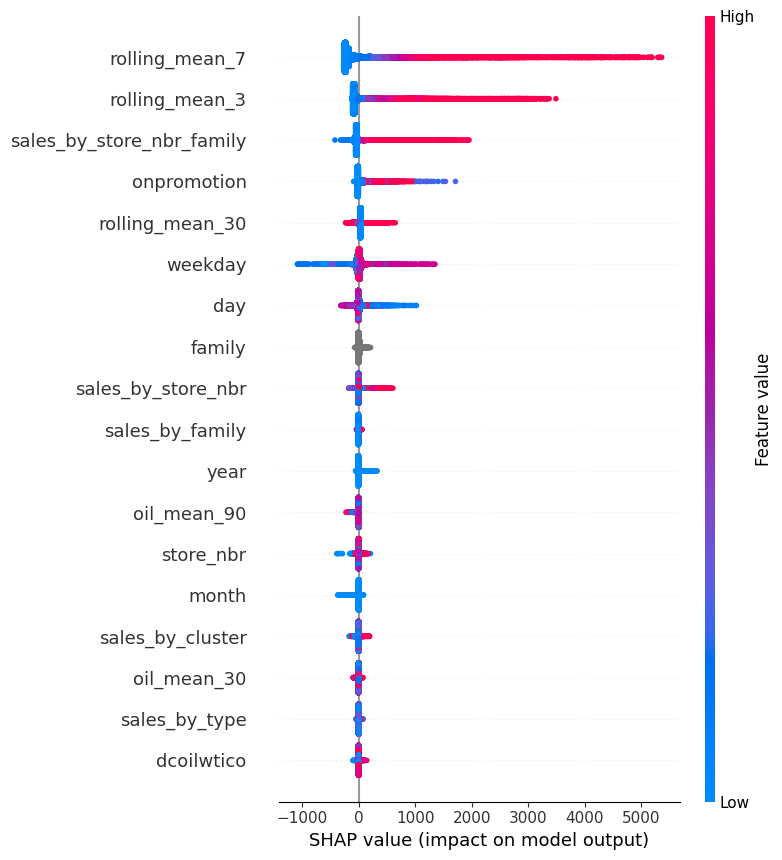

平均SHAPを保存しました: shap_avg/avg_shap_values.pkl
対応する特徴量データも保存しました: shap_avg/X_val_avg.pkl


In [ ]:
# ------------------------------
# 変数前提
# train: 元のデータフレーム
# x_all: 特徴量データ（DataFrame）
# folds: 学習/検証期間リスト
# ------------------------------

import pickle
import shap
import numpy as np
import os

# 出力用フォルダ
output_dir = "shap_avg"
os.makedirs(output_dir, exist_ok=True)

# ------------------------------
# 1. 各foldモデルのSHAP解析と可視化
# ------------------------------
shap_values_list = []  # 後で平均SHAPを作る用
X_val_list = []        # インデックス揃え用

for i in range(3):
    # モデル読み込み
    with open(f"model_lgb_fold{i}.pickle", "rb") as f:
        model = pickle.load(f)

    # 検証データ作成
    val_idx = (train["date"] >= folds[i]["val_start"]) & (train["date"] <= folds[i]["val_end"])
    X_val = x_all[val_idx]
    X_val_list.append(X_val)

    # SHAP解析
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val)
    shap_values_list.append(shap_values)

    # FoldごとのSummary Plot
    print(f"==== Fold {i} Summary SHAP ====")
    shap.summary_plot(shap_values, X_val)

    # ---- 個別予測 Force Plot ----
    example_idx = 0  # 好きな行を指定
    print(f"==== Fold {i} Individual Prediction SHAP ====")
    shap.force_plot(
        explainer.expected_value,
        shap_values[example_idx,:],
        X_val.iloc[example_idx,:],
        matplotlib=True  # Jupyterで表示
    )

# ------------------------------
# 2. 平均SHAP（近似）の作成
# ------------------------------
# インデックスを揃える（ここでは単純にX_val_list[0]を使う）
X_val_avg = X_val_list[0]

# 各foldのSHAP値を揃えて平均（簡易的な近似）
min_rows = min([sv.shape[0] for sv in shap_values_list])
shap_values_trimmed = [sv[:min_rows,:] for sv in shap_values_list]

# 平均SHAP値
avg_shap_values = np.mean(shap_values_trimmed, axis=0)

# ------------------------------
# 3. 平均SHAPのSummary Plot表示
# ------------------------------
print("==== Approximate Average SHAP ====")
shap.summary_plot(avg_shap_values, X_val_avg.iloc[:min_rows,:])

# ------------------------------
# 4. 平均SHAPの保存（Streamlit用）
# ------------------------------
X_val_avg_trimmed = X_val_avg.iloc[:min_rows, :]

with open(os.path.join(output_dir, "avg_shap_values.pkl"), "wb") as f:
    pickle.dump(avg_shap_values, f)

with open(os.path.join(output_dir, "X_val_avg.pkl"), "wb") as f:
    pickle.dump(X_val_avg_trimmed, f)

print(f"平均SHAPを保存しました: {output_dir}/avg_shap_values.pkl")
print(f"対応する特徴量データも保存しました: {output_dir}/X_val_avg.pkl")


#テストデータ

#テストデータ読み込み

In [ ]:
#テストデータ読み込み
test = pd.read_csv("/content/drive/MyDrive/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/test.csv")
print(test.shape)
print(test.head())

(28512, 5)
        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0


In [ ]:
#提出ファイルの形式確認
sample_submission = pd.read_csv("/content/drive/MyDrive/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/sample_submission.csv")
print(sample_submission.shape)
sample_submission

(28512, 2)


,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


#テストデータ結合

In [ ]:
test = pd.merge(test,store,on="store_nbr",how="left")
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13


In [ ]:
#データタイプをdatetimeに変換
test["date"] = pd.to_datetime(test["date"])

In [ ]:
test = pd.merge(test,oil,on="date",how="left")
print(test.shape)
test.head()

(28512, 13)


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,oil_mean_180,oil_mean_30,oil_mean_90
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,48.546167,48.334667,46.987667
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,48.546167,48.334667,46.987667
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,48.546167,48.334667,46.987667
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,48.546167,48.334667,46.987667
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8,48.546167,48.334667,46.987667


#テストデータ特徴量エンジニアリング

In [ ]:
# store_nbrとfamilyごとに日付順にソート
test = test.sort_values(["store_nbr", "family", "date"])

# 日付を分解して特徴量に
test["year"] = test["date"].dt.year
test["month"] = test["date"].dt.month
test["day"] = test["date"].dt.day

#曜日を分解して特徴量に(0が月曜日)
test["weekday"] = test["date"].dt.weekday

In [ ]:
#土日フラグ作成
test["is_weekend"] = test["weekday"].isin([5, 6]).astype(int)

##各カラムごとの平均売り上げ関数テストデータバージョン


In [ ]:
def sales_by_column_for_test(df1,df2,col):
  #指定のカラムごとに売り上げの平均を作成
  sales_by_col = df1.groupby(col)["sales"].mean().reset_index()
  #trainデータと売り上げ平均をしてにカラムをキーにして結合
  df2 = pd.merge(df2,sales_by_col,on=col,how="left")
  #カラム目の変更処理
  df2 = df2.rename(columns={"sales":f"sales_by_{col}"})

  return df2

In [ ]:
test = sales_by_column_for_test(train,test,"store_nbr")
test

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,oil_mean_180,oil_mean_30,oil_mean_90,year,month,day,weekday,is_weekend,sales_by_store_nbr
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.80,48.546167,48.334667,46.987667,2017,8,16,2,0,254.534889
1,3002670,2017-08-17,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,47.07,48.510944,48.357000,46.951556,2017,8,17,3,0,254.534889
2,3004452,2017-08-18,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.59,48.484167,48.406667,46.932333,2017,8,18,4,0,254.534889
3,3006234,2017-08-19,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.59,48.457389,48.468667,46.913111,2017,8,19,5,1,254.534889
4,3008016,2017-08-20,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.59,48.427222,48.562333,46.888444,2017,8,20,6,1,254.534889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3022139,2017-08-27,54,SEAFOOD,0,El Carmen,Manabi,C,3,47.65,48.180444,48.588667,46.718222,2017,8,27,6,1,198.975799
28508,3023921,2017-08-28,54,SEAFOOD,0,El Carmen,Manabi,C,3,46.40,48.139222,48.478000,46.682333,2017,8,28,0,0,198.975799
28509,3025703,2017-08-29,54,SEAFOOD,0,El Carmen,Manabi,C,3,46.46,48.104944,48.369333,46.662000,2017,8,29,1,0,198.975799
28510,3027485,2017-08-30,54,SEAFOOD,0,El Carmen,Manabi,C,3,45.96,48.064000,48.227667,46.635778,2017,8,30,2,0,198.975799


In [ ]:
test = sales_by_column_for_test(train,test,"family")
test

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,oil_mean_180,oil_mean_30,oil_mean_90,year,month,day,weekday,is_weekend,sales_by_store_nbr,sales_by_family
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.80,48.546167,48.334667,46.987667,2017,8,16,2,0,254.534889,6.101236
1,3002670,2017-08-17,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,47.07,48.510944,48.357000,46.951556,2017,8,17,3,0,254.534889,6.101236
2,3004452,2017-08-18,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.59,48.484167,48.406667,46.932333,2017,8,18,4,0,254.534889,6.101236
3,3006234,2017-08-19,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.59,48.457389,48.468667,46.913111,2017,8,19,5,1,254.534889,6.101236
4,3008016,2017-08-20,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.59,48.427222,48.562333,46.888444,2017,8,20,6,1,254.534889,6.101236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3022139,2017-08-27,54,SEAFOOD,0,El Carmen,Manabi,C,3,47.65,48.180444,48.588667,46.718222,2017,8,27,6,1,198.975799,22.163190
28508,3023921,2017-08-28,54,SEAFOOD,0,El Carmen,Manabi,C,3,46.40,48.139222,48.478000,46.682333,2017,8,28,0,0,198.975799,22.163190
28509,3025703,2017-08-29,54,SEAFOOD,0,El Carmen,Manabi,C,3,46.46,48.104944,48.369333,46.662000,2017,8,29,1,0,198.975799,22.163190
28510,3027485,2017-08-30,54,SEAFOOD,0,El Carmen,Manabi,C,3,45.96,48.064000,48.227667,46.635778,2017,8,30,2,0,198.975799,22.163190


In [ ]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'dcoilwtico', 'year', 'month', 'day',
       'weekday', 'is_weekend', 'sales_by_store_nbr', 'sales_by_family',
       'sales_by_type', 'sales_by_cluster', 'sales_by_store_nbr_family',
       'rolling_mean_3', 'rolling_mean_7', 'rolling_mean_30', 'oil_mean_180',
       'oil_mean_30', 'oil_mean_90', 'is_regional_holiday', 'is_holiday_flag',
       'is_national_holiday', 'is_local_holiday'],
      dtype='object')

In [ ]:
test.columns

Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'city', 'state',
       'type', 'cluster', 'dcoilwtico', 'oil_mean_180', 'oil_mean_30',
       'oil_mean_90', 'year', 'month', 'day', 'weekday', 'is_weekend',
       'sales_by_store_nbr', 'sales_by_family'],
      dtype='object')

In [ ]:
test = sales_by_column_for_test(train,test,"type")
test = sales_by_column_for_test(train,test,"cluster")

##2つのカラムでの平均売り上げテストデータバージョン

In [ ]:
def sales_by_columns_for_test(df1,df2,col1,col2):
  #過去のデータをcol1とcol2ごとにグループ化して平均を算出
  past_sale_mean = df1.groupby([col1,col2])["sales"].mean().reset_index()

  #求めたcol1とcol2ごとの平均をもとのデータフレームと結合
  df2 = pd.merge(df2,past_sale_mean,on=[col1,col2],how="left")
  df2 = df2.rename(columns={"sales":f"sales_by_{col1}_{col2}"})

  return df2

In [ ]:
test = sales_by_columns_for_test(train,test,"store_nbr","family")

##移動平均を追加

In [ ]:
test = pd.merge(test,rolling_features,on=["store_nbr","family"],how="left")

In [ ]:
test.columns

Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'city', 'state',
       'type', 'cluster', 'dcoilwtico', 'oil_mean_180', 'oil_mean_30',
       'oil_mean_90', 'year', 'month', 'day', 'weekday', 'is_weekend',
       'sales_by_store_nbr', 'sales_by_family', 'sales_by_type',
       'sales_by_cluster', 'sales_by_store_nbr_family', 'rolling_mean_3',
       'rolling_mean_7', 'rolling_mean_30'],
      dtype='object')

##祝日フラグ付け

In [ ]:
# local(state)
test["is_holiday_flag"] = 0

# 4) merge（left join で train の行数はそのまま、該当があれば情報が付く）
test = test.merge(regional.assign(is_regional_holiday=1), on=['date', 'state'], how='left')
# 5) フラグ化（NaN -> 0）
test['is_regional_holiday'] = test['is_regional_holiday'].fillna(0).astype(int)


In [ ]:
# national
national = holidays[(holidays['locale']=='National') & (holidays['is_holiday']==1)][['date']].drop_duplicates()
test = test.merge(national.assign(is_national_holiday=1), on='date', how='left')
test['is_national_holiday'] = test['is_national_holiday'].fillna(0).astype(int)

# local (city)
local = holidays[(holidays['locale']=='Local') & (holidays['is_holiday']==1)][['date','locale_name']].drop_duplicates()
local = local.rename(columns={'locale_name':'city'})
test = test.merge(local.assign(is_local_holiday=1), on=['date','city'], how='left')
test['is_local_holiday'] = test['is_local_holiday'].fillna(0).astype(int)

# 最終的な休みフラグ（必要に応じて OR）
test['is_holiday_flag'] = ((test['is_national_holiday']==1) |
                            (test['is_regional_holiday']==1) |
                            (test['is_local_holiday']==1)).astype(int)

In [ ]:
test.columns

Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'city', 'state',
       'type', 'cluster', 'dcoilwtico', 'oil_mean_180', 'oil_mean_30',
       'oil_mean_90', 'year', 'month', 'day', 'weekday', 'is_weekend',
       'sales_by_store_nbr', 'sales_by_family', 'sales_by_type',
       'sales_by_cluster', 'sales_by_store_nbr_family', 'rolling_mean_3',
       'rolling_mean_7', 'rolling_mean_30', 'is_holiday_flag',
       'is_regional_holiday', 'is_national_holiday', 'is_local_holiday'],
      dtype='object')

#テストデータセット作成

##データタイプ変換

In [ ]:
for col in features_type_changed:
  test[col] = test[col].astype("category")

In [ ]:
# 説明変数と目的変数のリスト作成
#dateカラムそのものは、datetimeになっているため、説明変数には含めない
test_features = ["store_nbr","family","sales_by_store_nbr", "sales_by_family", "onpromotion", "year", "month", "day","weekday",
               "sales_by_store_nbr_family","rolling_mean_3","rolling_mean_7",
               "rolling_mean_30","sales_by_type","sales_by_cluster","dcoilwtico","oil_mean_30", "oil_mean_90"]


x_test = test[test_features]

#学習したモデルを用いたテストデータの推論

In [ ]:
pred = np.zeros((len(x_test),len([0,1,2])))
pred

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
len(pred)

28512

In [ ]:

def predict_lgb( original_df,
                 input_x,
                 list_nfold=[0,1,2],
                 ):
  #テストデータ数×fold数分の0を格納したリスト作成
  pred = np.zeros((len(input_x),len(list_nfold)))

  #fold数(3周)分モデルを読み込み、それぞれのモデルで予測値を出し、リストに格納していく
  for nfold in list_nfold:
    #学習したモデルの読み込み
    filename = "model_lgb_fold{}.pickle".format(nfold)
    with open(filename,"rb") as f:
      model = pickle.load(f)

    #予測値を出し、predリストに格納
    pred[:,nfold] = model.predict(input_x)

  #予測値のリストをデータフレームにする
  pred_df = pd.DataFrame(pred,columns=["fold0","fold1","fold2"])

  #それぞれのモデルでの予測値の平均を格納したデータフレームを作成
  pred_df_mean = pd.DataFrame({"pred":pred_df.mean(axis = 1)})

  #予測値の平均を格納したデータフレームに各データのIDカラムをつけて、提出ファイルと同じ形にする
  pred_df = pd.concat([original_df["id"],pred_df_mean],axis=1)

  print("Done")

  return pred_df

In [ ]:
test_pred = predict_lgb(test,
                      x_test,
                      list_nfold=[0,1,2]
                      )

Done


In [ ]:
test_pred

,id,pred
0,3000888,7.940024
1,3002670,5.890063
2,3004452,5.987922
3,3006234,4.957272
4,3008016,1.507504
...,...,...
28507,3022139,0.151485
28508,3023921,-0.733706
28509,3025703,-0.225881
28510,3027485,1.648909


#提出用ファイル作成

In [ ]:
df_submit = test_pred.rename(columns={"pred":"sales"})
df_submit

,id,sales
0,3000888,7.940024
1,3002670,5.890063
2,3004452,5.987922
3,3006234,4.957272
4,3008016,1.507504
...,...,...
28507,3022139,0.151485
28508,3023921,-0.733706
28509,3025703,-0.225881
28510,3027485,1.648909


In [ ]:
#ファイル出力
df_submit.to_csv("submission_baseline.csv",index=None)

#テストデータSHAP値

In [ ]:
test_features_for_app = ["store_nbr_shap","family_shap","sales_by_store_nbr", "sales_by_family", "onpromotion", "year", "month", "day","weekday",
               "sales_by_store_nbr_family","rolling_mean_3","rolling_mean_7",
               "rolling_mean_30","sales_by_type","sales_by_cluster","dcoilwtico","oil_mean_30", "oil_mean_90"]

In [ ]:
import pickle
import pandas as pd
import numpy as np
import shap

# 3モデル分のSHAP値と予測値を格納
shap_list = []
pred_list = []

for i in range(3):
    # モデルロード
    with open(f"model_lgb_fold{i}.pickle", "rb") as f:
        model = pickle.load(f)

    # 予測
    y_pred = model.predict(x_test)
    pred_list.append(y_pred)

    # SHAP値
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    shap_list.append(shap_values)

# -------------------
# 個別の平均SHAP値（行ごと）
# -------------------
shap_avg = np.mean(np.array(shap_list), axis=0)  # shape: n_samples x n_features
pred_avg = np.mean(np.array(pred_list), axis=0)  # shape: n_samples

# DataFrameに変換
test_shap_df = pd.DataFrame(shap_avg, columns=x_test.columns)
test_shap_df["pred_mean"] = pred_avg
test_shap_df = test_shap_df.rename(columns={"store_nbr":"store_nbr_shap"}) #store_nbr_shapに名前変更して、store_nbrのshap値を保存する
test_shap_df["store_nbr"] = test["store_nbr"].values
test_shap_df["date"] = test["date"].values
test_shap_df = test_shap_df.rename(columns={"family":"family_shap"}) #familyはshap値のfamilyもあるから、familyのshap値名前はfamily_shapにする
test_shap_df["family"] = test["family"].values


# 保存
test_shap_df.to_csv("shap_values_test_avg.csv", index=False)

# -------------------
# 全体平均SHAP値（特徴量ごと）
# -------------------
test_mean_shap = test_shap_df[test_features_for_app].abs().mean().reset_index()
test_mean_shap.columns = ["feature", "mean_abs_shap"]
test_mean_shap.to_csv("test_mean_shap.csv", index=False)


In [ ]:
explainer.expected_value

np.float64(356.7267074222851)

In [ ]:
expected_value = explainer.expected_value
df = pd.DataFrame([expected_value], columns=["expected_value"])

df.to_csv("expected_value.csv", index=False)



In [ ]:
test_shap_df.head()

,store_nbr_shap,family_shap,sales_by_store_nbr,sales_by_family,onpromotion,year,month,day,weekday,sales_by_store_nbr_family,...,rolling_mean_30,sales_by_type,sales_by_cluster,dcoilwtico,oil_mean_30,oil_mean_90,pred_mean,store_nbr,date,family
0,13.523489,-8.593757,-3.974336,-2.444309,-10.600778,-2.567202,0.322082,7.342116,-9.834387,-31.625048,...,29.598394,0.016970,-1.021000,0.120021,-0.022817,-1.073206,7.940024,1,2017-08-16,AUTOMOTIVE
1,9.857511,-6.149720,-3.154045,-2.370413,-10.320419,-2.712925,0.399760,6.626599,-23.035563,-28.983354,...,30.778925,-0.330651,-1.165642,0.124603,-0.034093,-1.120518,5.890063,1,2017-08-17,AUTOMOTIVE
2,6.670705,-8.634275,-3.931475,-2.358635,-11.744441,-2.477214,0.430034,4.375228,-6.520762,-31.612647,...,33.591006,0.012524,-0.626554,0.170606,0.032549,-1.168951,5.987922,1,2017-08-18,AUTOMOTIVE
3,-1.487648,-4.735328,-4.475624,-2.747567,-11.046310,-2.906761,0.708602,2.871956,33.044243,-31.862097,...,33.066930,-0.242335,-1.828159,0.386261,-0.057182,-1.323141,4.957272,1,2017-08-19,AUTOMOTIVE
4,-19.703774,3.287189,-4.996490,-2.041451,-6.433871,-3.053567,-0.194360,2.680329,22.246058,-29.482197,...,31.980512,-0.586038,-1.941649,0.523553,-0.234268,-1.228222,1.507504,1,2017-08-20,AUTOMOTIVE


In [ ]:
test_mean_shap

,feature,mean_abs_shap
0,store_nbr_shap,3.392755
1,family_shap,10.605312
2,sales_by_store_nbr,7.601942
3,sales_by_family,5.400171
4,onpromotion,57.285046
5,year,4.195169
6,month,3.088818
7,day,10.800262
8,weekday,58.889881
9,sales_by_store_nbr_family,55.427758


In [ ]:
# 必要ならインストール
!pip install joblib

import joblib
from google.colab import files




In [ ]:
# # 例：testデータ
# x_test.to_csv("x_test.csv", index=False)
# test.to_csv("test.csv", index=False)

# # 例：最終予測値（3モデル平均）
# np.save("test_pred.npy", test_pred)

# # 例：SHAP値（計算済み）
# np.save("shap_values.npy", shap_values)  # shap_values が numpy 配列の場合

In [ ]:
test_features_for_app = ["store_nbr","date","family","sales_by_store_nbr", "sales_by_family", "onpromotion", "year", "month", "day","weekday",
               "sales_by_store_nbr_family","rolling_mean_3","rolling_mean_7",
               "rolling_mean_30","sales_by_type","sales_by_cluster","dcoilwtico","oil_mean_30", "oil_mean_90"]

In [ ]:
import pandas as pd
import numpy as np

# ===============================
# ①validation_dataのshap算出
# ===============================

# testデータに予測値を結合
# testに実績（true sales列）がある場合
if "sales" in test.columns:
    test_pred_df = test.copy()
    test_pred_df["pred_mean"] = test_pred["pred"]
    test_pred_df = test_pred_df[["id", "store_nbr", "date", "sales", "pred_mean"]]
else:
    # テストデータに実績がない場合
    test_pred_df = pd.concat([test[test_features_for_app], test_pred["pred"]], axis=1)
    test_pred_df.rename(columns={"pred": "pred_mean"}, inplace=True)

test_pred_df.to_csv("predictions.csv", index=False)
print("✅ predictions.csv 保存完了")


# ===============================
# ② 各データのSHAP値
# ===============================

# shap_values（numpy配列）をDataFrame化
val_shap_df = pd.DataFrame(shap_values, columns=X_val_avg.columns)

# 元データの識別列を追加
if "store_nbr" in train.columns and "date" in train.columns:
    val_shap_df["store_nbr"] = train.loc[train.index[:len(val_shap_df)], "store_nbr"].values
    val_shap_df["date"] = train.loc[train.index[:len(val_shap_df)], "date"].values

val_shap_df.to_csv("val_shap_values.csv", index=False)
print("✅ val_shap_values.csv 保存完了")


# ===============================
# ③ 平均SHAP値（全体傾向）
# ===============================

val_mean_shap = pd.DataFrame({
    "feature": X_val_avg.columns,
    "mean_abs_shap": np.abs(avg_shap_values).mean(axis=0)
})

val_mean_shap.to_csv("val_mean_shap.csv", index=False)
print("✅ val_mean_shap.csv 保存完了")




✅ predictions.csv 保存完了
✅ val_shap_values.csv 保存完了
✅ val_mean_shap.csv 保存完了


In [ ]:
test_pred_df.columns

Index(['store_nbr', 'date', 'family', 'sales_by_store_nbr', 'sales_by_family',
       'onpromotion', 'year', 'month', 'day', 'weekday',
       'sales_by_store_nbr_family', 'rolling_mean_3', 'rolling_mean_7',
       'rolling_mean_30', 'sales_by_type', 'sales_by_cluster', 'dcoilwtico',
       'oil_mean_30', 'oil_mean_90', 'pred_mean'],
      dtype='object')

In [ ]:
test_shap_df.columns


Index(['store_nbr_shap', 'family_shap', 'sales_by_store_nbr',
       'sales_by_family', 'onpromotion', 'year', 'month', 'day', 'weekday',
       'sales_by_store_nbr_family', 'rolling_mean_3', 'rolling_mean_7',
       'rolling_mean_30', 'sales_by_type', 'sales_by_cluster', 'dcoilwtico',
       'oil_mean_30', 'oil_mean_90', 'pred_mean', 'store_nbr', 'date',
       'family'],
      dtype='object')

In [ ]:
test_mean_shap

,feature,mean_abs_shap
0,store_nbr_shap,3.392755
1,family_shap,10.605312
2,sales_by_store_nbr,7.601942
3,sales_by_family,5.400171
4,onpromotion,57.285046
5,year,4.195169
6,month,3.088818
7,day,10.800262
8,weekday,58.889881
9,sales_by_store_nbr_family,55.427758


In [ ]:
test_shap_df

,store_nbr_shap,family_shap,sales_by_store_nbr,sales_by_family,onpromotion,year,month,day,weekday,sales_by_store_nbr_family,...,rolling_mean_30,sales_by_type,sales_by_cluster,dcoilwtico,oil_mean_30,oil_mean_90,pred_mean,store_nbr,date,family
0,13.523489,-8.593757,-3.974336,-2.444309,-10.600778,-2.567202,0.322082,7.342116,-9.834387,-31.625048,...,29.598394,0.016970,-1.021000,0.120021,-0.022817,-1.073206,7.940024,1,2017-08-16,AUTOMOTIVE
1,9.857511,-6.149720,-3.154045,-2.370413,-10.320419,-2.712925,0.399760,6.626599,-23.035563,-28.983354,...,30.778925,-0.330651,-1.165642,0.124603,-0.034093,-1.120518,5.890063,1,2017-08-17,AUTOMOTIVE
2,6.670705,-8.634275,-3.931475,-2.358635,-11.744441,-2.477214,0.430034,4.375228,-6.520762,-31.612647,...,33.591006,0.012524,-0.626554,0.170606,0.032549,-1.168951,5.987922,1,2017-08-18,AUTOMOTIVE
3,-1.487648,-4.735328,-4.475624,-2.747567,-11.046310,-2.906761,0.708602,2.871956,33.044243,-31.862097,...,33.066930,-0.242335,-1.828159,0.386261,-0.057182,-1.323141,4.957272,1,2017-08-19,AUTOMOTIVE
4,-19.703774,3.287189,-4.996490,-2.041451,-6.433871,-3.053567,-0.194360,2.680329,22.246058,-29.482197,...,31.980512,-0.586038,-1.941649,0.523553,-0.234268,-1.228222,1.507504,1,2017-08-20,AUTOMOTIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3.483288,-5.994026,-3.652086,-8.671517,-12.001632,-3.364158,0.111119,-6.496568,47.355361,-30.673072,...,32.159023,0.435194,-3.449315,0.436211,-0.381314,-0.578511,0.151485,54,2017-08-27,SEAFOOD
28508,-0.547589,-5.805961,-2.942230,-7.055328,-11.822484,-2.579030,0.779515,-6.679869,-5.469065,-29.129775,...,28.579609,1.446652,0.419833,-0.179602,-0.110872,-0.416093,-0.733706,54,2017-08-28,SEAFOOD
28509,-0.855381,-3.928683,-3.264773,-7.319700,-11.035971,-2.683643,0.093596,-2.351834,-21.630389,-28.078673,...,34.289177,0.592779,0.023253,-0.089301,-0.296274,-0.625651,-0.225881,54,2017-08-29,SEAFOOD
28510,-0.581459,-5.455224,-3.882431,-7.107627,-11.051700,-2.815843,-0.190417,7.481927,-21.024867,-29.578475,...,33.910221,-0.134525,-0.155954,-0.097020,-0.272318,-0.854217,1.648909,54,2017-08-30,SEAFOOD
